# 🦠🧪Covid-19 Vaccine Distribution 🧪🦠

Optimising a vaccine distribution plan for the UK in response to the Covid-19 virus.

### Import Packages and Data

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as matPoly
import pandas as pd
import numpy as np
import _pickle as cPickle
from selenium import webdriver
from  geopy.geocoders import Nominatim
import time
from shapely.geometry import Point

In [115]:
infected = pd.read_excel('Data//Historic COVID-19 Dashboard Data.xlsx', sheet_name='UTLAs', skiprows=7)
deaths = pd.read_excel('Data//COVID-19-total-announced-deaths-10-April-2020.xlsx', sheet_name='COVID19 total deaths by trust', skiprows=15)
population = pd.read_csv('Data//UK_population_densities.csv')

### Creating geo-objects for UK regions

Here we will use the Selenium package to get UK region polygon data from openstreetmap.

In [3]:
# Open Chrome client
driver = webdriver.Chrome(executable_path='/Users/newuser/Desktop/Programming/VaccineDistribution/chromedriver')

In [21]:
def get_poly_id(region):
    '''Returns the openstreetmap ID for a given region'''
    driver.get('https://nominatim.openstreetmap.org/')
    search_box = driver.find_element_by_id('q')
    search_box.send_keys(region)
    driver.find_element_by_class_name('btn-primary').click()
    driver.find_element_by_link_text('details').click()
    poly_id = driver.find_elements_by_xpath("//a[contains(@href, 'relation')]")[0].get_attribute("href").split('/')[-1]
    return(poly_id)
    
def get_poly(poly_id):
    '''Returns a list of lat/lon strings for a given openstreetmap ID'''
    driver.get('http://polygons.openstreetmap.fr/')
    search_box = driver.find_element_by_id('id')
    search_box.send_keys(poly_id)
    driver.find_elements_by_xpath("//input[@type='submit']")[0].click()
    poly_id = driver.find_elements_by_xpath("//a[contains(@href, 'get_poly')]")[0].click()
    texts = driver.find_element_by_tag_name("body").text.split('END')
    texts = [text.split('\n') for text in texts]
    polys = [[tuple(map(float,coord.lstrip(' ').split(' '))) for coord in t if len(coord.lstrip(' ').split(' ')) == 2] for t in texts[:-2]]
    return(polys)

We have commented out the following (Raw NBconvert) to stop it doing the scrape again. Just load in the pickle file.

Mistakes found with Polygons:
    - Manchester -> Greater Manchester [Apparently these are different]
    - Cornwall and Isles of Scilly -> (Cornwall).union(Isles of Scilly) [Was missing out Cornwall with original]
    - Bedford -> Bedford UK [Was originally using the US version of Bedford]

In [170]:
with open('polygons.pkl', 'rb') as f:
    polygons = pickle.load(f)
print(f'Collected {len(polygons)} out of {len(infected)}')

Collected 151 out of 151


### Plotting UK regions

In [150]:
def draw_screen_poly( lats, lons, m, color):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = matPoly( list(xy), facecolor=plt.cm.autumn_r(color) if type(color)==float else color , alpha=0.4 )
    plt.gca().add_patch(poly)

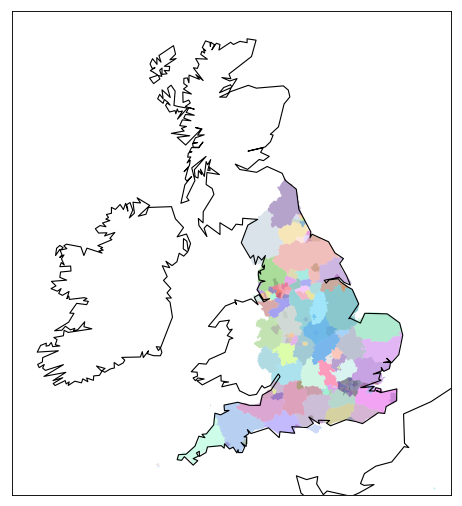

In [155]:
def plot_uk(set_of_polygons, region_colours = [], coords_of_hospitals={}, only_in_poly=False, w=10e5, h=11e5, res='l'):
    plt.figure(figsize=(12, 8), dpi=80)
    m = Basemap(projection='gnom', lat_0=54.3, lon_0=-4, width=w, height=h, resolution=res)
    m.drawcoastlines()

    if only_in_poly:
        total_poly = Polygon(polygons[set_of_polygons[-2]][0])
    
    for k,P in enumerate(set_of_polygons):
        if P == 'England ':
            continue
        for p in polygons[P]:
            if only_in_poly:
                try:
                    total_poly = total_poly.union(Polygon(p))
                except:
                    None
            lats = [i[1] for i in p]
            lons = [i[0] for i in p]
            if not region_colours:
                draw_screen_poly( lats, lons, m , list(np.random.random(size=3)))
            else:
                draw_screen_poly( lats, lons, m , color = region_colours[k])
            
    for hospital in coords_of_hospitals:
        h = hospital_locs[hospital]

        if not only_in_poly or Point(h).within(total_poly):
            m.scatter(h[0], h[1], color = 'k', latlon = True)

    plt.show()
    
plot_uk(polygons)

### Getting hospital regions

In [25]:
def get_coords(name):
    '''Returns the lat lon coords from google maps'''
    driver.get('https://www.google.co.uk/maps/')
    search_box = driver.find_element_by_id('searchboxinput')
    search_box.send_keys(name)
    driver.find_element_by_id('searchbox-searchbutton').click()
    time.sleep(7)
    if not driver.find_elements_by_xpath("//span[contains(@class, 'widget-pane-link')]"):
        places = driver.find_elements_by_xpath("//div[@class ='section-result-title-container']")
        if not places:
            return
        places[0].click()
        time.sleep(7)
    address = [j.text for j in driver.find_elements_by_xpath("//span[contains(@class, 'widget-pane-link')]") if j.text != ''][0]
    print(address)
    geolocator = Nominatim()
    loc = geolocator.geocode(address)
    while loc == None:
        address = ','.join(address.split(',')[1:])
        loc = geolocator.geocode(address)
        if len(address) == 0:
            print(address)
            hospital_errors.append(address)
            return
    print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)
    return((loc.latitude,loc.longitude))

In [26]:
with open('hospitals.pkl', 'rb') as f:
    hospital_locs = pickle.load(f)
print(f'Collected {len([1 for h in hospital_locs if hospital_locs[h] != None])} out of {len(deaths) - 2}.')

Collected 172 out of 172.


### Check which polygons hospitals are in

In [27]:
repeats = {}

for row in infected.itertuples():
    if row[2] == 'Unconfirmed' or row[2] == 'England ':
        continue
    for hospital in hospital_locs:
        if row[2] in polygons and hospital in hospital_locs:
            for poly in polygons[row[2]]:
                if Point(hospital_locs[hospital]).within(Polygon(poly)):
                    if hospital not in repeats:
                        repeats[hospital] = [row[2]]
                    else:
                        repeats[hospital] += [row[2]]
                    print(f'{hospital} in {row[2]}')

SOUTH TEES HOSPITALS NHS FOUNDATION TRUST in Middlesbrough
NORTH TEES AND HARTLEPOOL NHS FOUNDATION TRUST in Stockton-on-Tees
COUNTY DURHAM AND DARLINGTON NHS FOUNDATION TRUST in Darlington
WARRINGTON AND HALTON TEACHING HOSPITALS NHS FOUNDATION TRUST in Warrington
BLACKPOOL TEACHING HOSPITALS NHS FOUNDATION TRUST in Blackpool
HULL UNIVERSITY TEACHING HOSPITALS NHS TRUST in Kingston upon Hull, City of
HULL UNIVERSITY TEACHING HOSPITALS NHS TRUST in East Riding of Yorkshire
HUMBER TEACHING NHS FOUNDATION TRUST in East Riding of Yorkshire
NORTHERN LINCOLNSHIRE AND GOOLE NHS FOUNDATION TRUST in North Lincolnshire
TEES, ESK AND WEAR VALLEYS NHS FOUNDATION TRUST in York
YORK TEACHING HOSPITAL NHS FOUNDATION TRUST in York
DERBYSHIRE HEALTHCARE NHS FOUNDATION TRUST in Derby
UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS FOUNDATION TRUST in Derby
UNIVERSITY HOSPITALS OF LEICESTER NHS TRUST in Leicester
NOTTINGHAMSHIRE HEALTHCARE NHS FOUNDATION TRUST in Nottingham
NOTTINGHAM UNIVERSITY HOSPITALS 

BARKING, HAVERING AND REDBRIDGE UNIVERSITY HOSPITALS NHS TRUST in Southwark
BARTS HEALTH NHS TRUST in Southwark
CENTRAL AND NORTH WEST LONDON NHS FOUNDATION TRUST in Southwark
CHELSEA AND WESTMINSTER HOSPITAL NHS FOUNDATION TRUST in Southwark
CROYDON HEALTH SERVICES NHS TRUST in Southwark
EAST LONDON NHS FOUNDATION TRUST in Southwark
GUY'S AND ST THOMAS' NHS FOUNDATION TRUST in Southwark
HCA UK - The Lister in Southwark
HCA UK - The Princess Grace in Southwark
HCA UK - The Wellington Hospital North Building in Southwark
HOMERTON UNIVERSITY HOSPITAL NHS FOUNDATION TRUST in Southwark
IMPERIAL COLLEGE HEALTHCARE NHS TRUST in Southwark
KING'S COLLEGE HOSPITAL NHS FOUNDATION TRUST in Southwark
KINGSTON HOSPITAL NHS FOUNDATION TRUST in Southwark
LEWISHAM AND GREENWICH NHS TRUST in Southwark
LONDON NORTH WEST UNIVERSITY HEALTHCARE NHS TRUST in Southwark
NORTH EAST LONDON NHS FOUNDATION TRUST in Southwark
NORTH MIDDLESEX UNIVERSITY HOSPITAL NHS TRUST in Southwark
OXLEAS NHS FOUNDATION TRUST in

There are currently multiple regions belonging to the same hospital, which shouldn't happen. This is because certain polygons contain others.

There are 2 ways for us to get round this that I can see: merge polygons with major overlap and take the union of hospitals, or take the hospital to be in the smaller of the 2 regions (since it mostly likely provides for that region). We will go for the second option for now as it seems easier and keeps the most infomation.

In [28]:
hospitalRegion = {}

for hospital in repeats:
    i = np.argmin([sum([Polygon(p).area for p in polygons[r]]) for r in repeats[hospital]])
    hospitalRegion[hospital] = repeats[hospital][i]

We now have a map from hospitals to regions.

In [29]:
hospitalRegion

{'SOUTH TEES HOSPITALS NHS FOUNDATION TRUST': 'Middlesbrough',
 'NORTH TEES AND HARTLEPOOL NHS FOUNDATION TRUST': 'Stockton-on-Tees',
 'COUNTY DURHAM AND DARLINGTON NHS FOUNDATION TRUST': 'Darlington',
 'WARRINGTON AND HALTON TEACHING HOSPITALS NHS FOUNDATION TRUST': 'Warrington',
 'BLACKPOOL TEACHING HOSPITALS NHS FOUNDATION TRUST': 'Blackpool',
 'HULL UNIVERSITY TEACHING HOSPITALS NHS TRUST': 'Kingston upon Hull, City of',
 'HUMBER TEACHING NHS FOUNDATION TRUST': 'East Riding of Yorkshire',
 'NORTHERN LINCOLNSHIRE AND GOOLE NHS FOUNDATION TRUST': 'North Lincolnshire',
 'TEES, ESK AND WEAR VALLEYS NHS FOUNDATION TRUST': 'York',
 'YORK TEACHING HOSPITAL NHS FOUNDATION TRUST': 'York',
 'DERBYSHIRE HEALTHCARE NHS FOUNDATION TRUST': 'Derby',
 'UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS FOUNDATION TRUST': 'Derby',
 'UNIVERSITY HOSPITALS OF LEICESTER NHS TRUST': 'Leicester',
 'NOTTINGHAMSHIRE HEALTHCARE NHS FOUNDATION TRUST': 'Nottingham',
 'NOTTINGHAM UNIVERSITY HOSPITALS NHS TRUST': 'No

### Merge Data

Here we will take data from all tables, format it nicely, and add our metrics.

In [120]:
## The following regions were labelled different to population tables.
region_map = {'Kingston upon Hull, City of': 'Hull', 'Herefordshire, County of': 'Herefordshire',
             'Bristol, City of': 'Bristol', 'Brighton and Hove': 'Brighton & Hove',
             'Cornwall and Isles of Scilly': 'Cornwall', 'St. Helens': 'St Helens',
             'Hackney and City of London': 'Hackney'}
rev_region_map = {v:k for k,v in region_map.items()}

In [121]:
df_I = infected.iloc[:,[1,-1]]
df_I.columns = ['Region', 'Infected']

df_I = df_I.replace({"Region": region_map})

df_P = population[['District','Ceremonial county','Density (per km²)']]
df_P.columns = ['Region','County','Density']
counties = df_P.groupby('County', as_index=False).mean().rename(columns = {'County':'Region'})
df_P = pd.concat([df_P[['Density','Region']], counties])

df_I = df_I.merge(df_P, on='Region', how='left')

df_I = df_I.replace({"Region": rev_region_map})

df_D = deaths[['Name', 'Total']]
df_D.columns = ['Hospital', 'Deaths']
df_D = df_D[~df_D.isnull().T.all()] # Remove null lines
df_D['Region'] = [hospitalRegion[hospital] if hospital in hospitalRegion else float('nan') for hospital in df_D['Hospital']]

df = df_I.merge(df_D[['Region', 'Deaths']].groupby('Region', as_index=False).sum(), on='Region', how='left')

/Applications/anaconda3/envs/Python/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


We are left with about 50 out of 220 regions that don't have deaths associated with them. Need to check these out.

In [122]:
unknown = df[df['Deaths'].isnull()]
display(unknown.head())
print(f'{len(unknown)} unknown deaths out of {len(df)}')

,Region,Infected,Density,Deaths
0,Unconfirmed,2455,NaN,NaN
1,Hartlepool,64,997.0,NaN
3,Redcar and Cleveland,139,558.0,NaN
6,Halton,159,1624.0,NaN
8,Blackburn with Darwen,106,1087.0,NaN


52 unknown deaths out of 163


TopologyException: Input geom 1 is invalid: Self-intersection at or near point -104.99706293625694 39.961265000288826 at -104.99706293625694 39.961265000288826


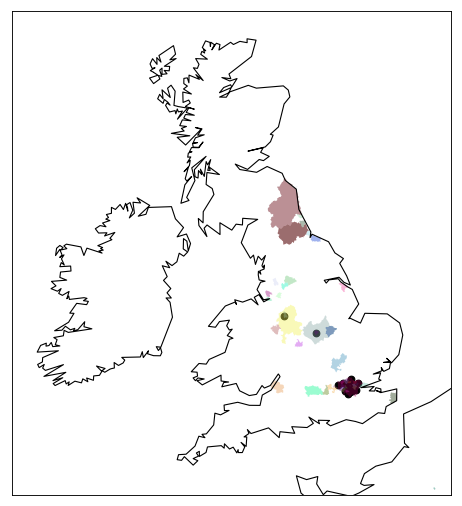

In [123]:
plot_uk(list(df[df['Deaths'].isnull()]['Region']), hospital_locs, only_in_poly=True)

For now we will just remove them...

In [124]:
df = df[~df['Deaths'].isnull()]

In [125]:
df

,Region,Infected,Density,Deaths
2,Middlesbrough,235,2608.000000,78.0
4,Stockton-on-Tees,173,962.000000,20.0
5,Darlington,109,540.000000,64.0
7,Warrington,241,1160.000000,29.0
9,Blackpool,108,3997.000000,30.0
...,...,...,...,...
157,Suffolk,360,824.400000,11.0
158,Surrey,1238,1126.727273,348.0
159,Warwickshire,513,560.000000,71.0
160,West Sussex,363,1285.571429,107.0


### New Metrics

Now we can add our metrics!

In [127]:
df['Mortality'] = df['Deaths'] / df['Infected']
df['DeathsPerDensity'] = df['Deaths'] / df['Density']
df['InfectedPerDensity'] = df['Infected'] / df['Density']

In [128]:
df

,Region,Infected,Density,Deaths,Mortality,DeathsPerDensity,InfectedPerDensity
2,Middlesbrough,235,2608.000000,78.0,0.331915,0.029908,0.090107
4,Stockton-on-Tees,173,962.000000,20.0,0.115607,0.020790,0.179834
5,Darlington,109,540.000000,64.0,0.587156,0.118519,0.201852
7,Warrington,241,1160.000000,29.0,0.120332,0.025000,0.207759
9,Blackpool,108,3997.000000,30.0,0.277778,0.007506,0.027020
...,...,...,...,...,...,...,...
157,Suffolk,360,824.400000,11.0,0.030556,0.013343,0.436681
158,Surrey,1238,1126.727273,348.0,0.281099,0.308859,1.098757
159,Warwickshire,513,560.000000,71.0,0.138402,0.126786,0.916071
160,West Sussex,363,1285.571429,107.0,0.294766,0.083231,0.282365


### Plots

In [161]:
def normalize(x):
    return(list((x - np.min(x)) / (np.max(x) - np.min(x))))

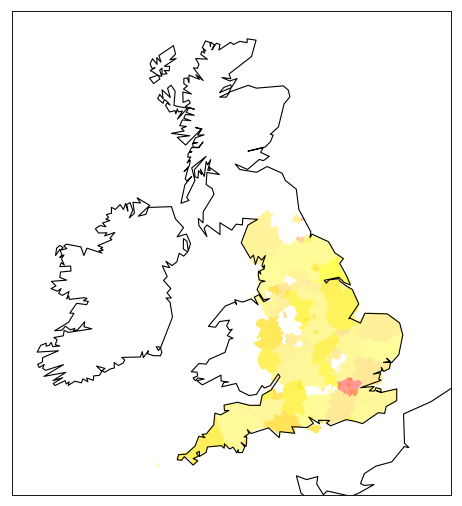

In [162]:
plot_uk(df['Region'], region_colours=normalize(df['Mortality']))

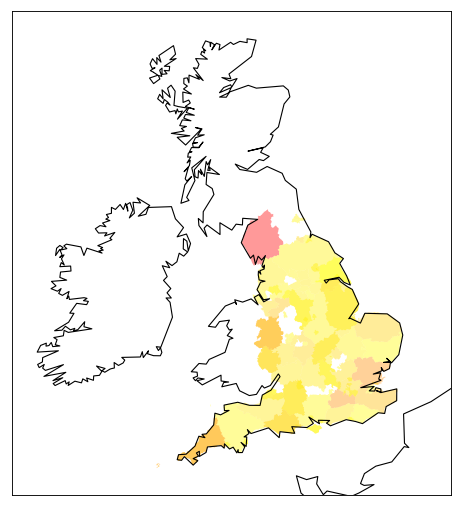

In [163]:
plot_uk(df['Region'], region_colours=normalize(df['DeathsPerDensity']))

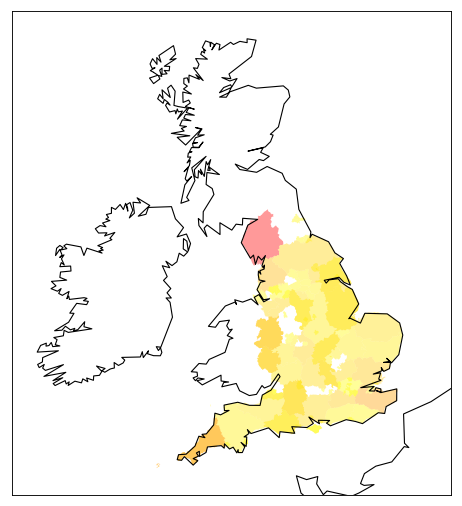

In [164]:
plot_uk(df['Region'], region_colours=normalize(df['InfectedPerDensity']))